<a href="https://colab.research.google.com/github/03axdov/Notebooks/blob/main/CatsAndDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf

In [2]:
URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

68616192/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.


In [3]:
import pathlib
PATH = pathlib.Path(train_dir)
print(len(list(PATH.glob('cats/*.jpg'))))
print(len(list(PATH.glob('dogs/*.jpg'))))

1000
1000


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 1000 files belonging to 2 classes.


In [5]:
class_names = train_dataset.class_names

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


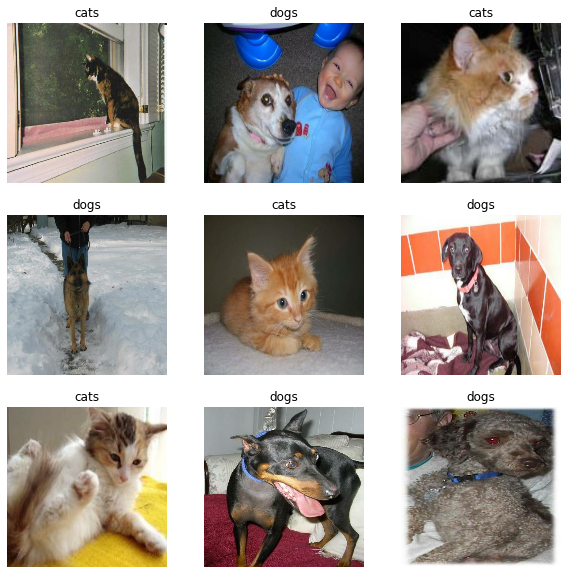

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset:
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()

In [7]:
print(tf.data.experimental.cardinality(validation_dataset))

tf.Tensor(32, shape=(), dtype=int64)


In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [9]:
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_dataset)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_dataset)}")

Number of validation batches: 26
Number of test batches: 6


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2)
])

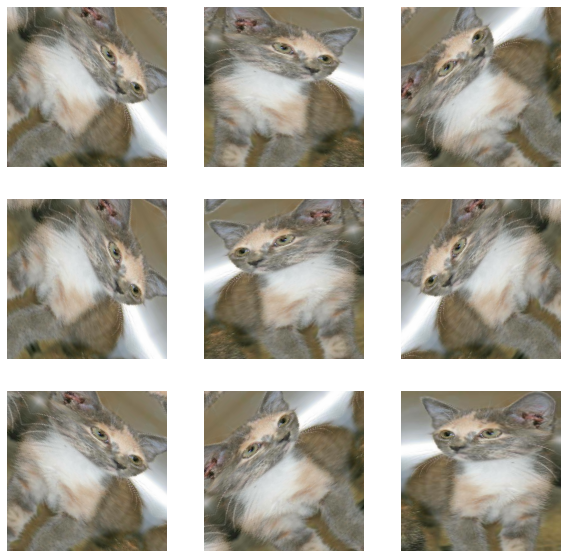

In [12]:
for images, labels in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = images[0]
  for i in range(9):
    plt.subplot(3,3,i+1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255.0)
    plt.axis("off")

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# rescale = tf.keras.layers.Rescaling( 1 / 127.5, offset=-1)

In [65]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights="imagenet")

In [66]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [67]:
base_model.trainable = False

In [68]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [69]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [70]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [71]:
inputs = tf.keras.Input(shape=(160,160,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [72]:
base_lr = 0.0001

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [73]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [74]:
len(model.trainable_variables)

2

In [75]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 3s 59ms/step - loss: 0.5903 - accuracy: 0.6411


In [76]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=initial_epochs
)

Epoch 1/10
63/63 [==============================] - 7s 62ms/step - loss: 0.5189 - accuracy: 0.7160 - val_loss: 0.3930 - val_accuracy: 0.8156
Epoch 2/10
63/63 [==============================] - 5s 78ms/step - loss: 0.3926 - accuracy: 0.8085 - val_loss: 0.2894 - val_accuracy: 0.8800
Epoch 3/10
63/63 [==============================] - 4s 61ms/step - loss: 0.3185 - accuracy: 0.8615 - val_loss: 0.2354 - val_accuracy: 0.9097
Epoch 4/10
63/63 [==============================] - 4s 61ms/step - loss: 0.2684 - accuracy: 0.8895 - val_loss: 0.1902 - val_accuracy: 0.9344
Epoch 5/10
63/63 [==============================] - 4s 62ms/step - loss: 0.2363 - accuracy: 0.9045 - val_loss: 0.1622 - val_accuracy: 0.9418
Epoch 6/10
63/63 [==============================] - 4s 61ms/step - loss: 0.2283 - accuracy: 0.9005 - val_loss: 0.1497 - val_accuracy: 0.9480
Epoch 7/10
63/63 [==============================] - 4s 61ms/step - loss: 0.2062 - accuracy: 0.9160 - val_loss: 0.1314 - val_accuracy: 0.9530
Epoch 8/10
63

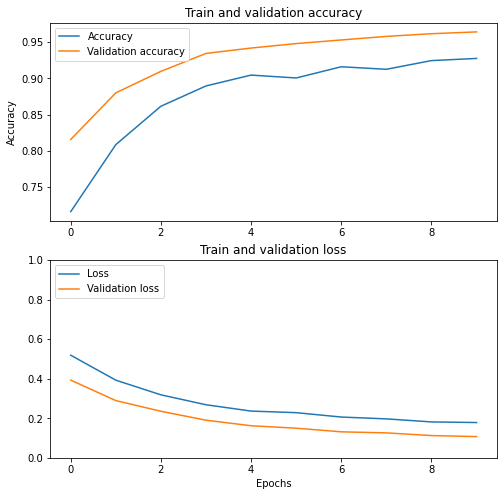

In [77]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epoch_range = range(initial_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2,1,1)
plt.plot(epoch_range, accuracy, label="Accuracy")
plt.plot(epoch_range, val_accuracy, label="Validation accuracy")
plt.title("Train and validation accuracy")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

plt.subplot(2,1,2)
plt.plot(epoch_range, loss, label="Loss")
plt.plot(epoch_range, val_loss, label="Validation loss")
plt.title("Train and validation loss")
plt.legend(loc="upper left")
plt.xlabel("Loss")
plt.ylim([0, 1])
plt.xlabel("Epochs")

plt.show()

In [78]:
base_model.trainable = True

In [79]:
print(f"Number of layers in the base model: {len(base_model.layers)}")

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model: 154


In [80]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr/10),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [81]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [82]:
len(model.trainable_variables)

56

In [83]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]
)

Epoch 10/20
63/63 [==============================] - 8s 78ms/step - loss: 0.1304 - accuracy: 0.9420 - val_loss: 0.0498 - val_accuracy: 0.9814
Epoch 11/20
63/63 [==============================] - 4s 67ms/step - loss: 0.1040 - accuracy: 0.9545 - val_loss: 0.0427 - val_accuracy: 0.9851
Epoch 12/20
63/63 [==============================] - 4s 68ms/step - loss: 0.0945 - accuracy: 0.9595 - val_loss: 0.0570 - val_accuracy: 0.9740
Epoch 13/20
63/63 [==============================] - 4s 66ms/step - loss: 0.0776 - accuracy: 0.9680 - val_loss: 0.0474 - val_accuracy: 0.9740
Epoch 14/20
63/63 [==============================] - 4s 66ms/step - loss: 0.0667 - accuracy: 0.9735 - val_loss: 0.0397 - val_accuracy: 0.9851
Epoch 15/20
63/63 [==============================] - 4s 68ms/step - loss: 0.0622 - accuracy: 0.9720 - val_loss: 0.0420 - val_accuracy: 0.9740
Epoch 16/20
63/63 [==============================] - 4s 66ms/step - loss: 0.0755 - accuracy: 0.9680 - val_loss: 0.0405 - val_accuracy: 0.9802
Epoch 

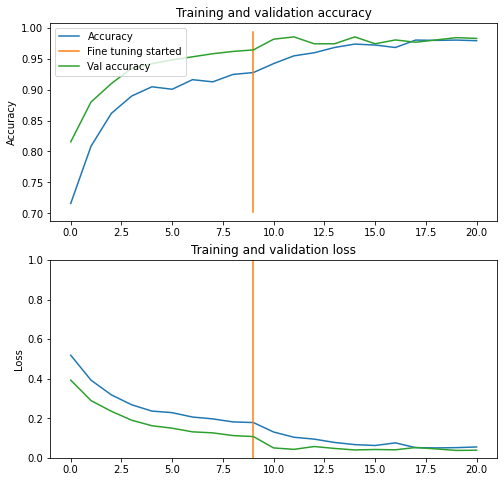

In [84]:
accuracy += history_fine.history["accuracy"]
val_accuracy += history_fine.history["val_accuracy"]

loss += history_fine.history["loss"]
val_loss += history_fine.history["val_loss"]

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(accuracy, label="Accuracy")
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Fine tuning started")
plt.plot(val_accuracy, label="Val accuracy")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy")
plt.legend(loc="upper left")

plt.subplot(2,1,2)
plt.plot(loss, label="Loss")
plt.ylim([0, 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Fine tuning started")
plt.plot(val_loss, label="Validation loss")
plt.ylabel("Loss")
plt.title("Training and validation loss")

plt.show()

In [90]:
print((tf.data.experimental.cardinality(test_dataset) * BATCH_SIZE).numpy())

192


In [85]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {accuracy}")

6/6 [==============================] - 1s 47ms/step - loss: 0.0118 - accuracy: 1.0000
Test accuracy: 1.0
